# Explore the raw data for Guatemale pilot area
* Forest disturbances
* Land Use
* Rivers
* Roads
* Parks
* Urban Settlements

In [146]:
import geopandas as gpd
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gdal

## Globals

In [147]:
years = [2018, 2019, 2020]
data_disturbances = '/mnt/uksa-storage/guatemala/disturbances/'
data_lui = '/mnt/uksa-storage/land_cover'
data_rivers = '/mnt/uksa-storage/guatemala/rivers'
data_roads = '/mnt/uksa-storage/guatemala/roads'
projection = 'EPSG:32615'
res_shp = 40

## Helpers

In [215]:
def rasterize(shp, dst, feat, epsg):
    cmd = f'gdal_rasterize -a_srs {epsg} -a {feat} -tr 10 10 -ot Int32 -a_nodata 0 {shp} {dst}'
    os.system(cmd)
    return

def read_lui(filename, year, labels):
    """Read LUI and return class counts in dataframe"""
    rst = rasterio.open(filename)
    data = rst.read(1)
    a, b = np.unique(data, return_counts=True)
    df = pd.DataFrame(index =a)
    df['lui'] = df.index.map(labels)
    df['counts']=b
    df['year']=year
    return rst, data, df

def rasterize_nofeat(shp, dst, epsg, res):
    cmd = f'gdal_rasterize -burn 1 -a_srs {epsg} -tr {res} {res} -ot Int32 {shp} {dst}'
    os.system(cmd)
    return

def distance_to_value(target_value, source, outfile):
    cmd = f"gdal_proximity.py -co BIGTIFF=YES -co COMPRESS=LZW -maxdist 4000 -nodata 4001 -ot Int16 -values {target_value} {source} {outfile} "
    os.system(cmd)
    return


# 1. Forest Disturbances

## Understand data

In [149]:
os.chdir(data_disturbances)

In [150]:
data = gpd.read_file('forestchange_footprint_current_change.shp')

In [151]:
data.shape

(34184, 6)

In [152]:
data.head()

,aoi,deliveryda,pkid,area_ha,enddate,geometry
0,1,20180202000000,40640,0.075333,20180202000000,"POLYGON ((-91.97514 15.50598, -91.97501 15.505..."
1,1,20180202000000,40641,0.037666,20180202000000,"POLYGON ((-91.97602 15.50698, -91.97615 15.506..."
2,1,20180202000000,40642,0.094164,20180202000000,"POLYGON ((-91.97539 15.51215, -91.97526 15.512..."
3,1,20180202000000,40643,0.075331,20180202000000,"POLYGON ((-91.97401 15.51227, -91.97413 15.512..."
4,1,20180202000000,40644,0.018833,20180202000000,"POLYGON ((-91.97325 15.50786, -91.97338 15.507..."


In [153]:
(data['deliveryda']==data['enddate']).sum()

34184

In [154]:
len(data['deliveryda'].unique())

75

In [155]:
data['deliveryda'].unique()

array(['20180202000000', '20180214000000', '20180226000000',
       '20180310000000', '20180322000000', '20180403000000',
       '20180415000000', '20180427000000', '20180509000000',
       '20180521000000', '20180602000000', '20180614000000',
       '20180626000000', '20180708000000', '20180720000000',
       '20180801000000', '20180813000000', '20180825000000',
       '20180906000000', '20180918000000', '20180930000000',
       '20181012000000', '20181024000000', '20181105000000',
       '20181117000000', '20181129000000', '20181211000000',
       '20181223000000', '20190104000000', '20190116000000',
       '20190128000000', '20190209000000', '20190221000000',
       '20190305000000', '20190317000000', '20190329000000',
       '20190410000000', '20190422000000', '20190504000000',
       '20190516000000', '20190528000000', '20190621000000',
       '20190703000000', '20190715000000', '20190727000000',
       '20190820000000', '20190925000000', '20191007000000',
       '20191019000000',

In [156]:
len(data['pkid'].unique())

34184

In [157]:
len(data['aoi'].unique())

1

In [158]:
# check projection 
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [159]:
# change projection to mercator
data= data.to_crs(projection)


In [160]:
data.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

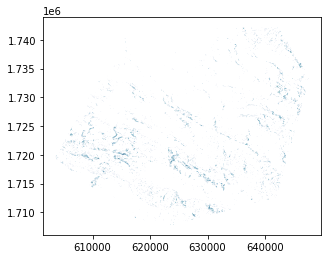

In [161]:
data.plot()

In [162]:
# only year
data['year'] = data['enddate'].str[:4]

In [163]:
a,b = np.unique(data['year'], return_counts = True)
print(a)
print(b)

['2018' '2019' '2020']
[16851 14374  2959]


In [164]:
# save shp
data.to_file('forest_change_mercator.shp')

In [165]:
data.groupby('year').aggregate(sum)

,pkid,area_ha
year,,
2018,826794315,638.501951
2019,929674385,458.482080
2020,217024896,82.441104


We note there has been much less deforestation in 2020 relative to the previous years

In [166]:
data.head()

,aoi,deliveryda,pkid,area_ha,enddate,geometry,year
0,1,20180202000000,40640,0.075333,20180202000000,"POLYGON ((609921.956 1714553.182, 609935.465 1...",2018
1,1,20180202000000,40641,0.037666,20180202000000,"POLYGON ((609826.861 1714664.203, 609813.352 1...",2018
2,1,20180202000000,40642,0.094164,20180202000000,"POLYGON ((609891.673 1715235.822, 609905.182 1...",2018
3,1,20180202000000,40643,0.075331,20180202000000,"POLYGON ((610040.200 1715250.467, 610026.692 1...",2018
4,1,20180202000000,40644,0.018833,20180202000000,"POLYGON ((610123.589 1714763.163, 610110.080 1...",2018


In [167]:
os.listdir()

['forestchange_footprint_current_change.cpg',
 'forestchange_footprint_current_change.dbf',
 'forestchange_footprint_current_change.prj',
 'forestchange_footprint_current_change.shp',
 'forestchange_footprint_current_change.shx',
 'forest_change_by_year.tif',
 'deforestation_2018.tif',
 'deforestation_2019.tif',
 'deforestation_2020.tif',
 'forest_change_mercator.shp',
 'forest_change_mercator.shx',
 'forest_change_mercator.dbf',
 'forest_change_mercator.cpg',
 'forest_change_mercator.prj']

## Rasterize data

In [168]:
# raster with all years
rasterize('forest_change_mercator.shp', 'forest_change_by_year.tif', 'year', 'EPSG:32615')

In [169]:
rst = rasterio.open('forest_change_by_year.tif')
rst.profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 4401, 'height': 3440, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603558.1124792217,
       0.0, -10.0, 1742194.128229793), 'tiled': False, 'interleave': 'band'}

In [170]:
rst_dt = rst.read(1)
a,b = np.unique(rst_dt, return_counts=True)

In [171]:
print(a)
print(b)

[   0 2018 2019 2020]
[15021061    64077    46052     8250]


The nb of 10x10m pixels matches the hectares deforested in the raw data - rasterization was succesful

## Raster masks by year

In [172]:
# deforestation mask per year - 1 binary raster for each year
with rasterio.open("forest_change_by_year.tif") as src:
    dst_profile = src.profile
    dst_profile.update(dtype=rasterio.int32, nodata=0)
    for yr in years:
        with rasterio.open(f"deforestation_{yr}.tif", 'w', **dst_profile) as dst:
            for ji, window in src.block_windows(1):
                r = np.array(src.read(1, window=window))
                m = r == yr
                dst.write(m.astype('int32'), window=window, indexes = 1)


In [173]:
# confirm the masks have been correctly produced
for yr in years:
    rst = rasterio.open(f"deforestation_{yr}.tif").read(1)
    print(f"In year {yr} there were {sum(sum(rst))} pixels deforested")

In year 2018 there were 64077 pixels deforested
In year 2019 there were 46052 pixels deforested
In year 2020 there were 8250 pixels deforested


# 2. Land Use

In [174]:
os.chdir(data_lui)

In [175]:
# LABELS
# let's see what the class labels correspond to
with open('GSI_LandNow_LCC_Delivery_2_ColourMap.clr') as f:
    lines = f.readlines()
    
labels = {}
for l in lines:
    labels.update({int(l.split(' ')[0]):l.split(' ')[-2]})
labels.update({11:'coffee'})
labels.update({-9999:'outside AOI'})



## Raw folder

In [176]:
# raw data from 2020
rst_raw_20, dt_raw_20, df_raw_20  = read_lui('2020/Raw/GSI_LandNow_LCC_2020_Iteration_2.tif', 2020, labels)

In [177]:
rst_raw_20.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

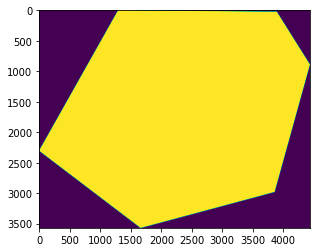

In [178]:
plt.imshow(dt_raw_20)

In [179]:
df_raw_20

,lui,counts,year
-9999,outside AOI,4427012,2020
1,Shrubs,250636,2020
2,Vegetation,116148,2020
3,Cropland,1404038,2020
4,Urban,206814,2020
5,vegetation,291522,2020
7,body,11177,2020
10,Forest,6348670,2020
11,coffee,2815326,2020


In [180]:
# raw data from 2017
rst_raw_17, dt_raw_17, df_raw_17  = read_lui('2017/Raw/GSI_LandNow_LCC_2017_Iteration_2.tif', 2017, labels)

In [181]:
rst_raw_17.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

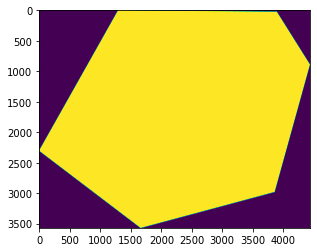

In [182]:
plt.imshow(dt_raw_17)

In [183]:
df_raw_17

,lui,counts,year
-9999,outside AOI,4427012,2017
1,Shrubs,372140,2017
2,Vegetation,226316,2017
3,Cropland,1466284,2017
4,Urban,235404,2017
5,vegetation,280857,2017
7,body,11752,2017
10,Forest,5649376,2017
11,coffee,3202202,2017


In [184]:
# confirm the AOI is the same in 2017 and 2020
df_raw_17['counts'].sum()==df_raw_20['counts'].sum()

True

In [185]:
# combine both years
raw_lui_combined = df_raw_17.append(df_raw_20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'outside AOI'),
  Text(1, 0, 'Shrubs'),
  Text(2, 0, 'Vegetation'),
  Text(3, 0, 'Cropland'),
  Text(4, 0, 'Urban'),
  Text(5, 0, 'vegetation'),
  Text(6, 0, 'body'),
  Text(7, 0, 'Forest'),
  Text(8, 0, 'coffee')])

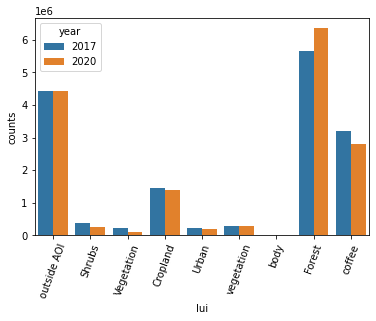

In [186]:
# Plot the counts in 2017 and 2020
ax = sns.barplot(x='lui', y='counts', hue='year', data = raw_lui_combined)
plt.xticks(rotation=70)

We note that total forest cover has increased between 2017 and 2020, as a result of a reduction in land cultivation: cropland and coffee classes are in dedcline

## Smoothed folder

In [187]:
# smoothed data from 2020
rst_smooth_20, dt_smooth_20, df_smooth_20  = read_lui('2020/Smoothed/GSI_LandNow_LCC_2020_Iteration_2_Smoothed.tif', 2020, labels)


In [188]:
rst_raw_20.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [189]:
df_raw_20

,lui,counts,year
-9999,outside AOI,4427012,2020
1,Shrubs,250636,2020
2,Vegetation,116148,2020
3,Cropland,1404038,2020
4,Urban,206814,2020
5,vegetation,291522,2020
7,body,11177,2020
10,Forest,6348670,2020
11,coffee,2815326,2020


In [190]:
# smoothed data from 2017
rst_smooth_17, dt_smooth_17, df_smooth_17  = read_lui('2017/Smoothed/GSI_LandNow_LCC_2017_Iteration_2_Smoothed.tif', 2017, labels)


In [191]:
# combine both years
smooth_lui_combined = df_smooth_17.append(df_smooth_20)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'outside AOI'),
  Text(1, 0, 'Shrubs'),
  Text(2, 0, 'Vegetation'),
  Text(3, 0, 'Cropland'),
  Text(4, 0, 'Urban'),
  Text(5, 0, 'vegetation'),
  Text(6, 0, 'body'),
  Text(7, 0, 'Forest'),
  Text(8, 0, 'coffee')])

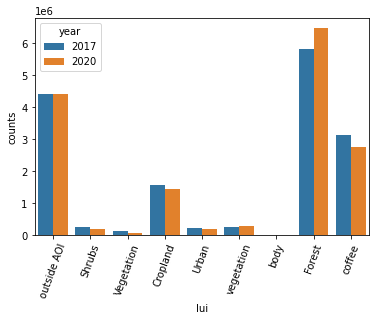

In [192]:
# Plot the counts in 2017 and 2020
ax = sns.barplot(x='lui', y='counts', hue='year', data = smooth_lui_combined)
plt.xticks(rotation=70)

We just use the smoothed LUI. Note that we'll train the model using the 2017 LUI, BUT make the projections for 2021 using the 2020 forest cover!

# 3. Area of Interet AOI
Derive a raster and a shapefile of the area of interest for the pilot DRI


In [193]:
# deforestation mask per year - 1 binary raster for each year
with rasterio.open('2017/Raw/GSI_LandNow_LCC_2017_Iteration_2.tif') as src:
    dst_profile = src.profile
    dst_profile.update(dtype=rasterio.int32, nodata=0)
    with rasterio.open("pilot_guatemala_aoi.tif", 'w', **dst_profile) as dst:
        for ji, window in src.block_windows(1):
            r = np.array(src.read(1, window=window))
            m = r >0
            dst.write(m.astype('int32'), window=window, indexes = 1)


In [194]:
dst = rasterio.open("pilot_guatemala_aoi.tif").read(1)

In [195]:
a, b = np.unique(dst, return_counts = True)
print(a)
print(b)

[0 1]
[ 4427012 11444331]


The number of AOI pixels matches the table above - all OK

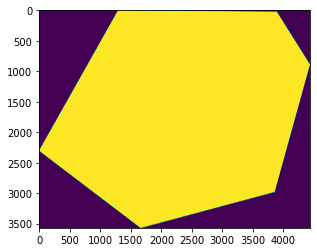

In [196]:
plt.imshow(dst)

# 4. Rivers
Let's explore the river data

In [197]:
os.chdir(data_rivers)

In [198]:
rivers = gpd.read_file('rios_gtm.shp')

In [199]:
rivers.crs

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_WGS_1984" ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: unknown
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [200]:
# change projection to mercator
rivers= rivers.to_crs(projection)
rivers.to_file('rivers_gtm_utm.shp')

In [201]:
rivers.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [202]:
rivers.head()

,gid,codigo,nombre,largo,naturaleza,tipo,geometry
0,1,8087,Sin Nombre,100.339636,0,0,"LINESTRING (749182.302 1555528.559, 749202.427..."
1,2,8090,Sin Nombre,294.270563,0,0,"LINESTRING (749182.302 1555528.559, 749174.865..."
2,3,8122,Canal,587.998245,0,0,"LINESTRING (659266.506 1554404.380, 659263.943..."
3,4,8088,Sin Nombre,415.201198,0,0,"LINESTRING (749373.490 1555846.560, 749349.427..."
4,5,8120,Rio Los Esclavos,3799.873026,0,0,"LINESTRING (787107.524 1557000.592, 787109.462..."


In [203]:
rivers['tipo'].unique()

array([0])

In [204]:
rivers['naturaleza'].unique()

array([0])

<AxesSubplot:>

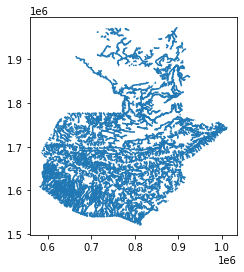

In [205]:
rivers.plot()

In [216]:
# rasterize
rasterize_nofeat('rivers_gtm_utm.shp', 'rivers_gtm.tif', projection, res_shp)


In [217]:
# confirm rasterization
dst = rasterio.open('rivers_gtm.tif').read(1)

In [218]:
dst.shape

(11330, 10766)

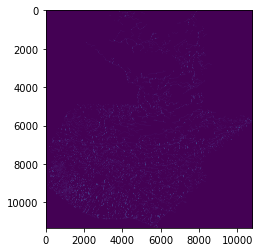

In [219]:
plt.imshow(dst)

In [220]:
sum(sum(dst))

626574

In [221]:
np.unique(dst)

array([0, 1], dtype=int32)

In [222]:
# distance to rivers
distance_to_value(1, 'rivers_gtm.tif', 'distance_rivers_gtm.tif')

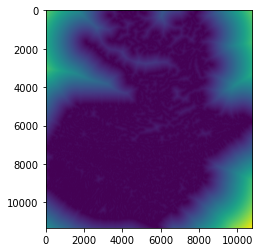

In [223]:
plt.imshow(rasterio.open('distance_rivers_gtm.tif').read(1))

# 5. Roads

In [224]:
os.chdir(data_roads)

In [225]:
roads = gpd.read_file('caminos_gtm.shp')

In [226]:
roads.crs

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_WGS_1984" ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: unknown
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [227]:
# change projection to mercator
roads= roads.to_crs(projection)
roads.to_file('roads_gtm_utm.shp')

In [228]:
roads.crs

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°W to 90°W - by country
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [230]:
# rasterize
rasterize_nofeat('roads_gtm_utm.shp', 'roads_gtm.tif',projection, res_shp)


In [231]:
# confirm rasterization
dst = rasterio.open('roads_gtm.tif').read(1)

In [232]:
dst.shape

(13216, 10834)

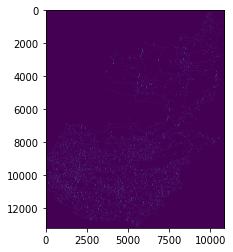

In [233]:
plt.imshow(dst)

In [234]:
sum(sum(dst))

891985

In [235]:
# distance to raods
distance_to_value(1, 'roads_gtm.tif', 'distance_roads_gtm.tif')

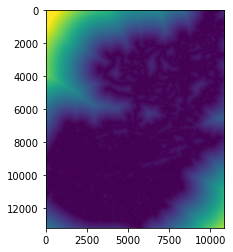

In [236]:
plt.imshow(rasterio.open('distance_roads_gtm.tif').read(1))

# 6. Parks


# 7. Urban Settlements

# 8. SRTM